<a href="https://colab.research.google.com/github/XingruiWang/Animefy/blob/master/Notebook/Animefy-yourself.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animefy yourself!

Github 项目在[这里](https://github.com/XingruiWang/Animefy/blob/master/README.md)，里边也有详细介绍与代码。


<img src="https://raw.githubusercontent.com/XingruiWang/Animefy/master/example/example.png" alt="example" style="width: 100%;" />


### 关于项目

这是一个基于StyleGAN2模型的"selfie2anime"项目。你可以使用现实世界的**自拍照片**得到你具有个性的**二次元头像**。


我们大作业的代码是根据StyleGAN2模型\[[官方代码](https://github.com/NVlabs/stylegan2)\]\[[论文](https://arxiv.org/abs/1912.04958)\]\[[视频介绍](https://youtu.be/c-NJtV9Jvp0)\]以及[Justin Pinkney](https://www.justinpinkney.com/)提出的layer swapping 技术 . 同时也参考了[Tetratrio](https://github.com/Tetratrio/stylegan2_pytorch)完成的Pytorch版本的StyleGAN2代码。

### 主要文件介绍

### 数据集

我们使用的数据集为[二次元头像数据集](http://www.seeprettyface.com/mydataset_page3.html#anime)，这个数据集摘选并处理自[DANBOORU2018](https://www.gwern.net/Danbooru2020#danbooru2018)，包含140000张动漫人脸（[百度网盘](https://pan.baidu.com/share/init?surl=8pHjzcOWhVF2u6LKOlT3yg)(提取码：JIMD)）

### 安装项目

1. 复制github项目：

In [1]:
!git clone https://github.com/XingruiWang/Animefy.git
%cd Animefy

Cloning into 'Animefy'...
remote: Enumerating objects: 302, done.
remote: Counting objects: 100% (302/302), done.
remote: Compressing objects: 100% (242/242), done.
remote: Total 302 (delta 113), reused 181 (delta 53), pack-reused 0
Receiving objects: 100% (302/302), 20.13 MiB | 2.66 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/Animefy


2. 配置依赖环境（需要在命令行完成）

```bash
conda env create -f environment/anime.yaml
conda activate anime
pip install -r requirements.txt
```

### 训练模型

（注：受限于数据传输，此处notebook使用了样例数据进行训练测试（原数据集2000张随机样本），但可能不能在别的机器上直接运行。如果需要重新运行，请先下载数据。）

- 可以用如下命令进行训练

In [ ]:
!python run_training.py settings_with_pretrain.yaml

Traceback (most recent call last):
  File "run_training.py", line 1008, in <module>
    main()
  File "run_training.py", line 1001, in main
    mp.spawn(run_distributed, nprocs=len(args.gpu), args=(args,))
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/spawn.py", line 199, in spawn
    return start_processes(fn, args, nprocs, join, daemon, start_method='spawn')
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/spawn.py", line 157, in start_processes
    while not context.join():
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/spawn.py", line 118, in join
    raise Exception(msg)
Exception: 

-- Process 3 terminated with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/spawn.py", line 19, in _wrap
    fn(i, *args)
  File "/content/Animefy/run_training.py", line 989, in run_distributed
    run(args)
  File "/content/Animefy/run_training.py", line 971, 

或者写成脚本`run.sh`

```bash
sh run.sh
```

* 此处`settings_with_pretrain.yaml`存储了训练中的配置参数。需要设置数据路径`data_dir`，以及与训练模型`g_file`和`d_file`

```yaml
# Here is an example training config file for 512x512 images.
channels: [32, 64, 128, 256, 512, 512, 512, 512]
tensorboard_log_dir: 'runs/stylegan2_512x512_with_pretrain_new_2'
tensorboard_image_interval: 20
checkpoint_dir: 'checkpoints/stylegan2_512x512_with_pretrain_new_2'
checkpoint_interval: 500
data_dir: /DATA2/wxr/anime_face
output_dir: train_output
gpu: [0, 1, 2, 3]
g_file: /home/wxr/stylegan2_pytorch_backup/checkpoints/stylegan2_512x512_with_pretrain_new_2/10000_2020-12-22_03-42-54/G.pth
d_file: /home/wxr/stylegan2_pytorch_backup/checkpoints/stylegan2_512x512_with_pretrain_new_2/10000_2020-12-22_03-42-54/D.pth
iterations: 10000

```

  * 初次训练时，应设置`G_file`为`ffhq`人脸数据集的pretrained模型，另外可以删掉`D_file`

- 我们实际训练过程使用了4张GPU (Titan V)，总共进行了20000次循环（并不是epoch，总共大约2天）。大约2000次循环后，二次元头像已经具有了较高质量（大约4小时）。

- 下载已经训练好的模型

### Layer Swapping

直接训练好的模型并不能用来进行高质量的“selfie2anime”，我们还需要采用layer swapping 技术进行模型调整。StyleGAN2的生成器具有不同的分辨率层，低分辨率层控制着人脸的头部姿势、方向等，高分辨率层控制着面部细节比如五官、肤色等。所以我们将生成真实人脸的生成器的**低分辨率层**（来自FFHQ数据集上的pretrain模型）和我们刚刚训练好的二次元生成模型的**高分辨率层**。这样可以生成具有人脸姿态和二次元风格的自定义头像

In [ ]:
!gdown --id 1BgMHyJwF7KvouTkJ-8MbHy6jDWURQqMo
!gdown --id 19vr5taIJSbNMiqihW1-vWSZkXUK7tdPR

In [ ]:
from blend import blend_models

G_out = blend_models("G_pretrain.pth", 
                     "Gs.pth", 
                     8, None)
G_out.save('G_blend.pth')

### 生成你的头像！

In [2]:
%mkdir raw
%mkdir latent
%mkdir generated

1. 把你自己的照片放到`raw`文件夹里

  这里使用了样例照片

In [3]:
!wget https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg -O raw/example.jpg

--2021-01-16 14:31:30--  https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332712 (325K) [image/jpeg]
Saving to: ‘raw/example.jpg’

raw/example.jpg     100%[===================>] 324.91K  1.76MB/s    in 0.2s    

2021-01-16 14:31:31 (1.76 MB/s) - ‘raw/example.jpg’ saved [332712/332712]



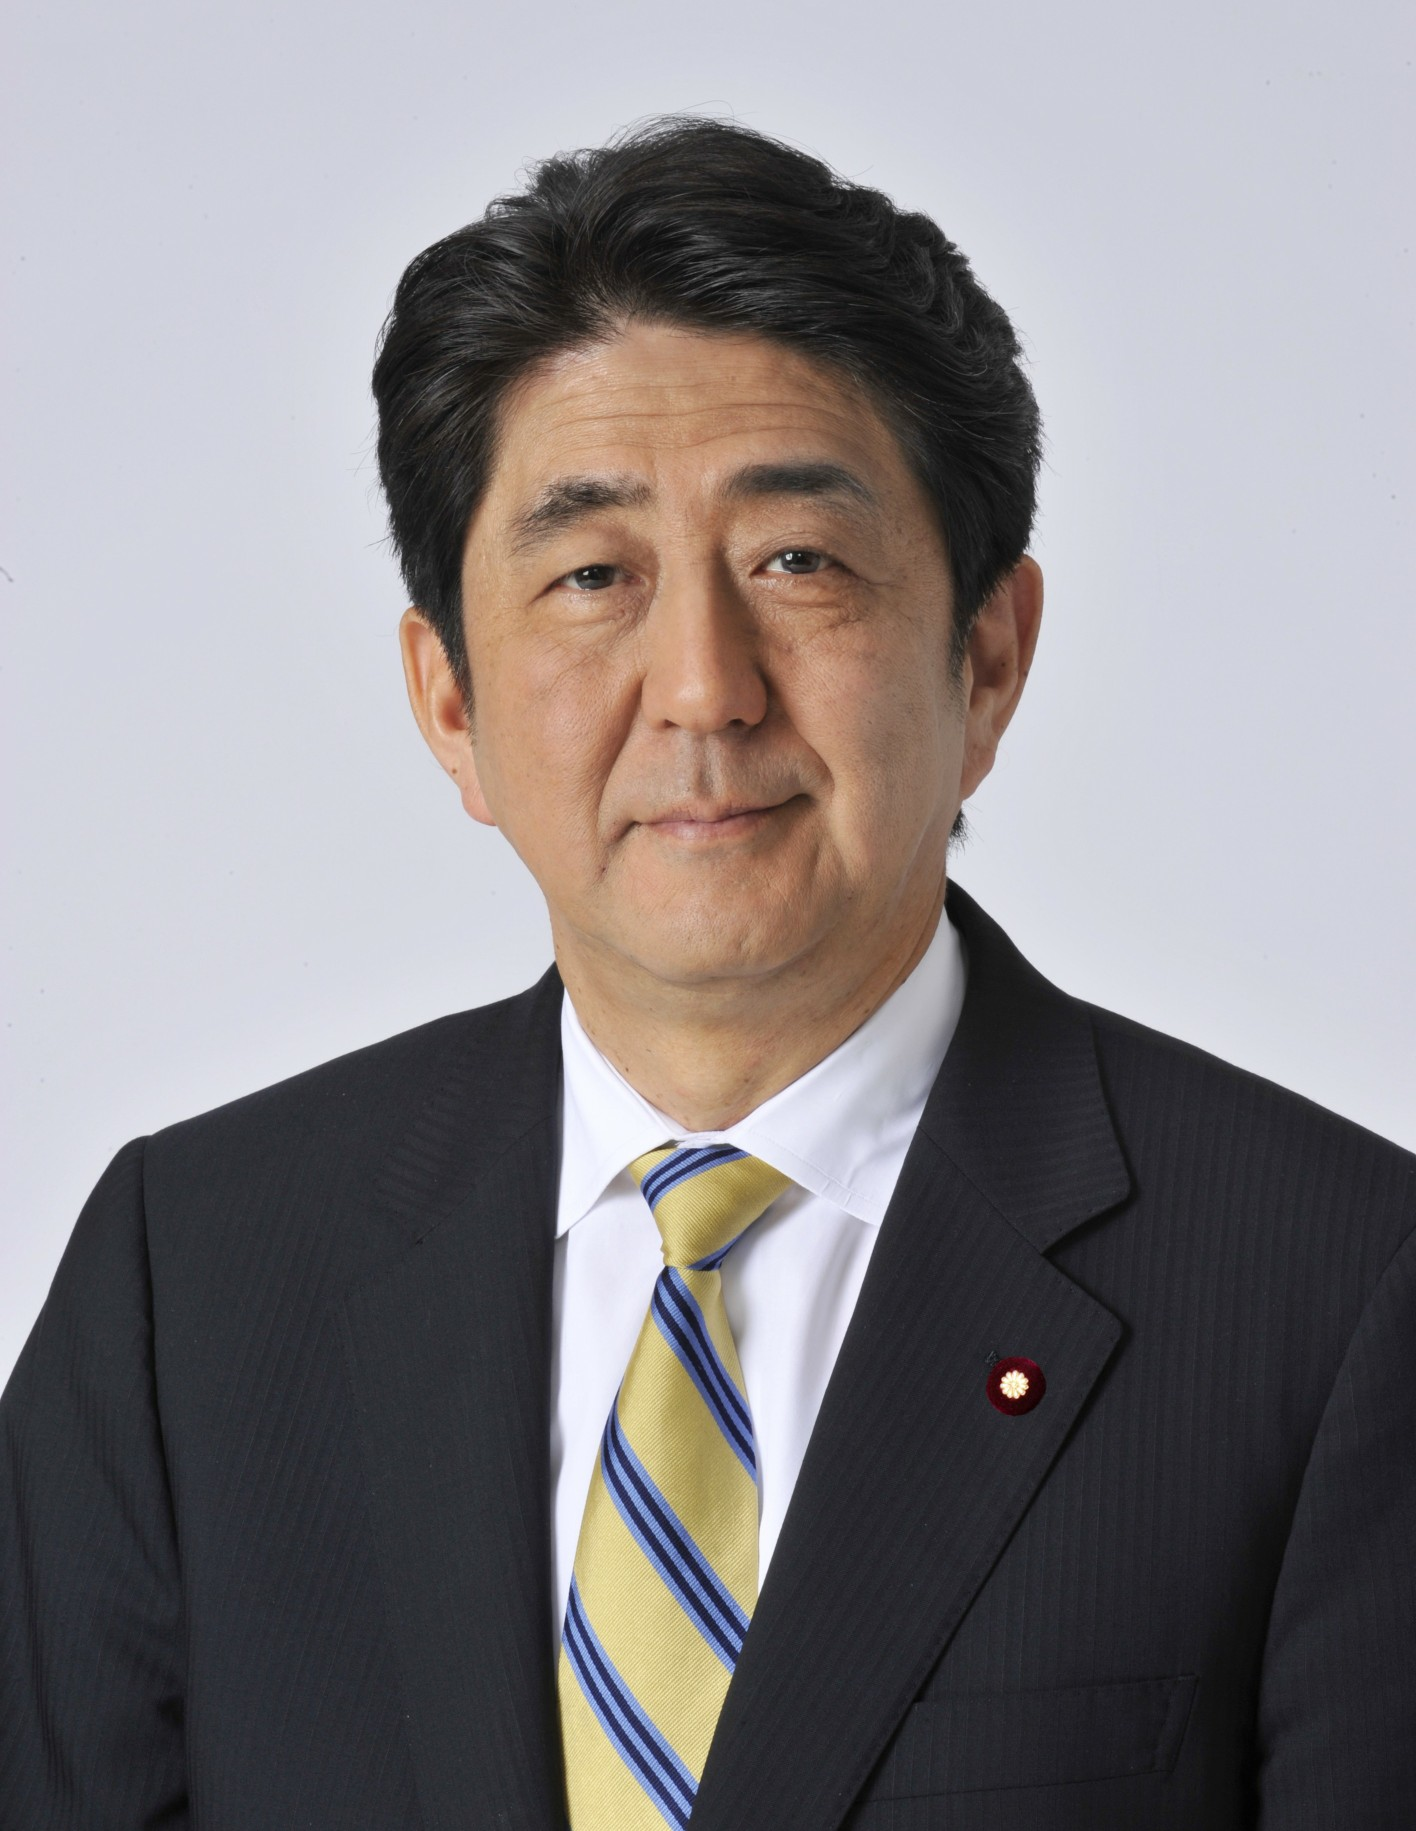

In [7]:
from IPython.display import Image
Image(filename='raw/example.jpg') 

2. 提取人脸

In [5]:
!python align_images.py raw aligned

2021-01-16 14:35:26.039382: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


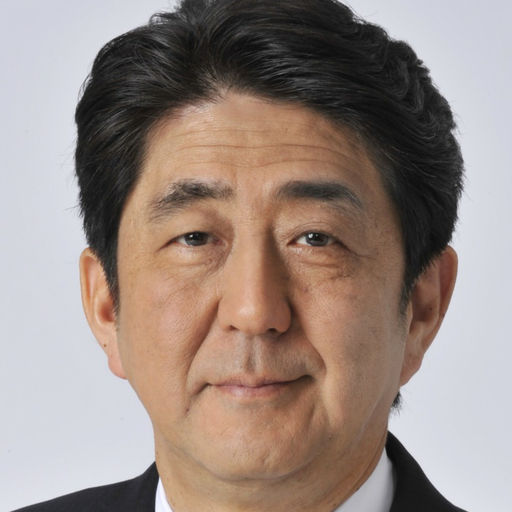

In [8]:
Image(filename='aligned/example_01.png') 

In [12]:
!python run_projector.py project_real_images --network=G_pretrain.pth --data_dir=aligned --output=latent/ --num_steps=200 --gpu=0

Loading images from "aligned"...
Done!
                          

Gathering dlatents...
                          

Done!
100% 10/10 [00:00<00:00, 144.73it/s]
;;;;;;;;;;;;;;;;;;;;;;;;;;;
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
                           

Projecting image(s) 1/1
loss: 1.618e+06, lpips_distance: 0.6396, lr: 0
noise_reg: 16.18
                                   

Projecting image(s) 1/1
loss: 1.617e+06, lpips_distance: 0.6364, lr: 0.01
noise_reg: 16.17
                                   

Project

  0%|          | 0/9 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


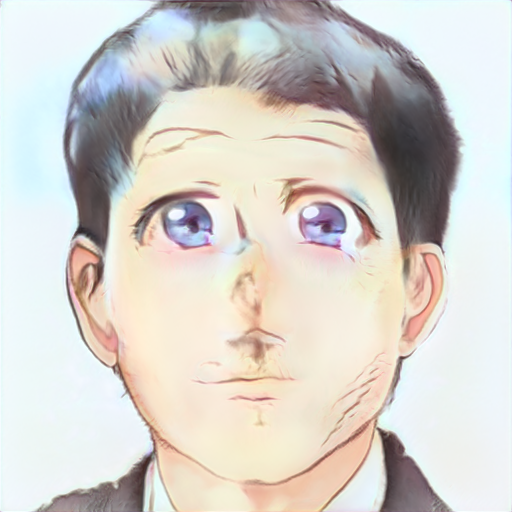

 11%|█         | 1/9 [00:00<00:07,  1.12it/s]

<class 'PIL.Image.Image'>


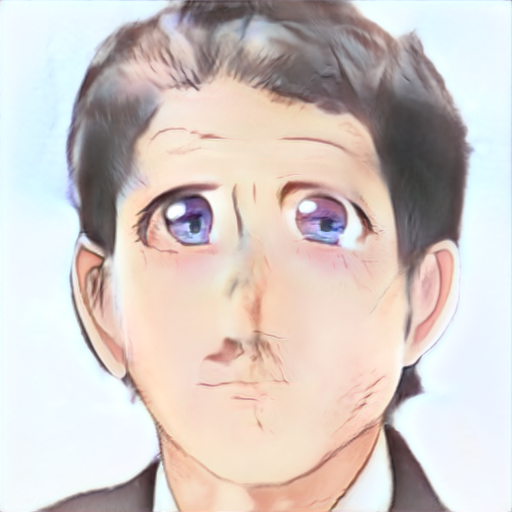

 33%|███▎      | 3/9 [00:01<00:04,  1.31it/s]

<class 'PIL.Image.Image'>


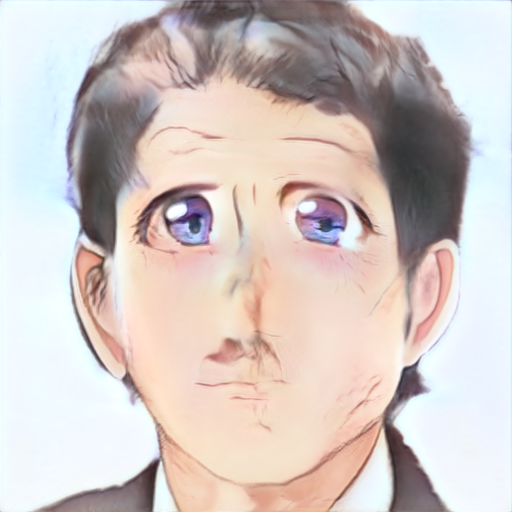

 44%|████▍     | 4/9 [00:02<00:04,  1.24it/s]

<class 'PIL.Image.Image'>


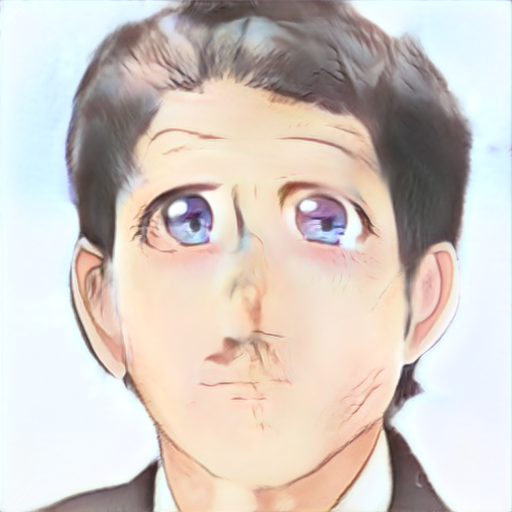

 56%|█████▌    | 5/9 [00:03<00:03,  1.21it/s]

<class 'PIL.Image.Image'>


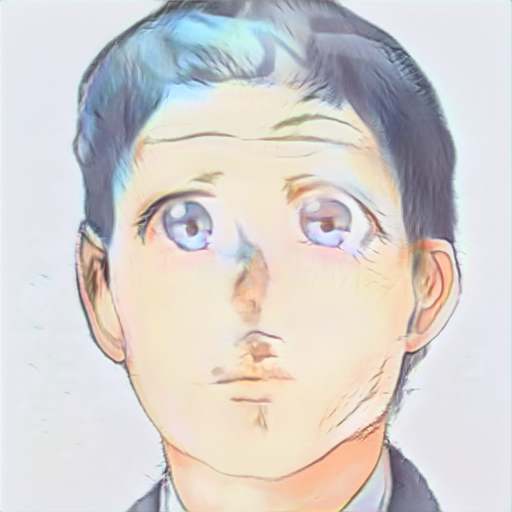

 67%|██████▋   | 6/9 [00:04<00:02,  1.19it/s]

<class 'PIL.Image.Image'>


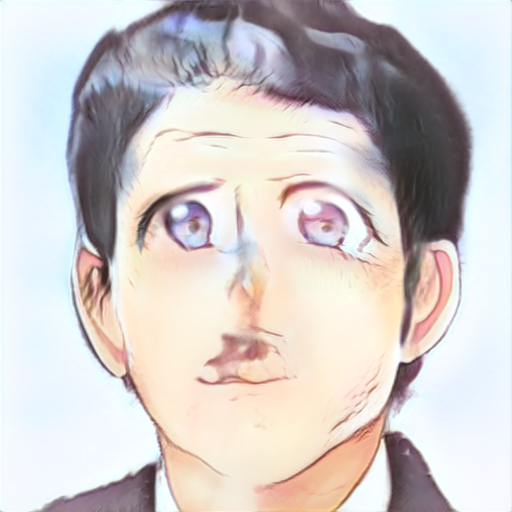

 78%|███████▊  | 7/9 [00:05<00:01,  1.20it/s]

<class 'PIL.Image.Image'>


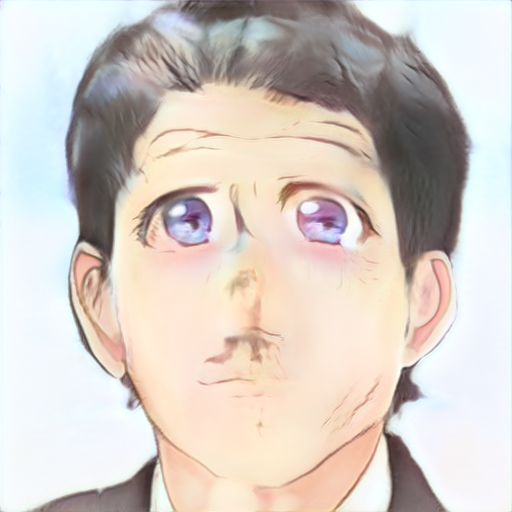

 89%|████████▉ | 8/9 [00:06<00:00,  1.21it/s]

<class 'PIL.Image.Image'>


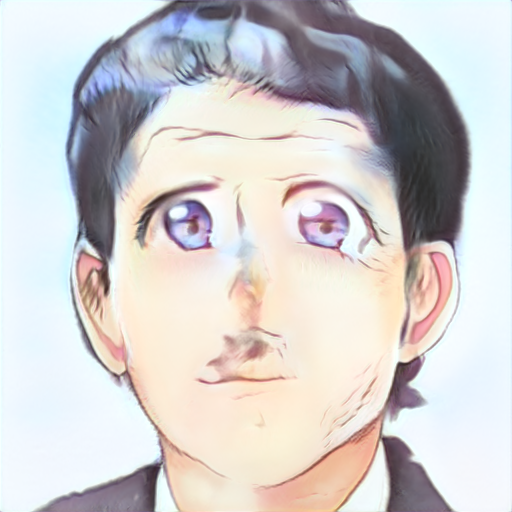

100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


In [13]:
import os
import numpy as np
import torch
import stylegan2
from stylegan2 import utils
import cv2 as cv
from google.colab.patches import cv2_imshow
from tqdm import tqdm
dir = 'latent'

G_blend = 'G_blend.pth'

def synthesis(G_file, latent_file):
    device = torch.device(0)
    G = stylegan2.models.load(G_file).G_synthesis 
    latent = np.load(latent_file, allow_pickle=True)
    G.to(device)
    latent = torch.tensor(latent[np.newaxis, ...]).to(device)
    out = G(latent)
    out = utils.tensor_to_PIL(out, pixel_min=-1, pixel_max=1)[0]
    return out

for l in tqdm(os.listdir(dir)):
  if l[-3:] == 'png':
    continue
  latent = os.path.join(dir, l)
  out = synthesis(G_blend, latent)
  print(type(out))
  display(out)



